# High-dynamic-range (HDR) tomography

The dynamic range is defined as the ratio of the maximum to minimum density in the distribution; for example, a dynamic range of $10^3$ means the peak density is one thousand times higher than the noise floor. Densities below $10^{-2}$ (as a fraction of the peak) are basically invisible to the naked eye and are therefore unimportant in most applications. However, low-density regions can be *very* important in high-power particle accelerators, where tiny fractional beam loss contributes to intensity-limiting radioactivation in the accelerator.

In [1]:
import os
import sys
import time

import matplotlib.lines
import matplotlib.ticker
import numpy as np
import scipy.ndimage
import ultraplot as plt
import xarray as xr

import ment

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "plasma"
plt.rc["colorbar.width"] = "1.2em"
plt.rc["grid"] = False
plt.rc["figure.facecolor"] = "white"

## Source distribution

As the ground truth/source distribution, we use a simulated beam in the Beam Test Facility (BTF) at Oak Ridge National Laboratory. The [PyORBIT](https://github.com/PyORBIT-Collaboration/PyORBIT3) simulation model represents the accelerator lattice as a series of symplectic transfer maps and incorporates space charge using a 3D particle-in-cell algorithm. The simulation used $8.5 \times 10^6$ "macroparticles" to represent the phase space distribution, populating low-density regions of the phase sapce. The following are the projections of the coordinates onto the $x$-$x'$ and axis and binned on a 2D grid.

In [3]:
def plot_image(values: np.ndarray, coords: list[np.ndarray], log: bool = True, ax=None, **plot_kws) -> None:
    """Plot image in log scale."""
    plot_kws.setdefault("colorbar", True)
    plot_kws.setdefault("colorbar_kw", dict())    
    
    values = values.copy()
    values = values + np.min(values[values > 0.0])
    values = values / np.max(values)
    if log:
        values = np.log10(values + 1.00e-12)
        plot_kws.setdefault("vmax", 0.0)

    ax.pcolormesh(coords[0], coords[1], values.T, **plot_kws)

def plot_points(x: np.ndarray, bins: int, limits: list[tuple[float, float]], **plot_kws) -> None:
    """Plot histogram in log scale."""
    values, edges = np.histogramdd(x, bins=bins, range=limits)
    plot_image(values, edges, **plot_kws)

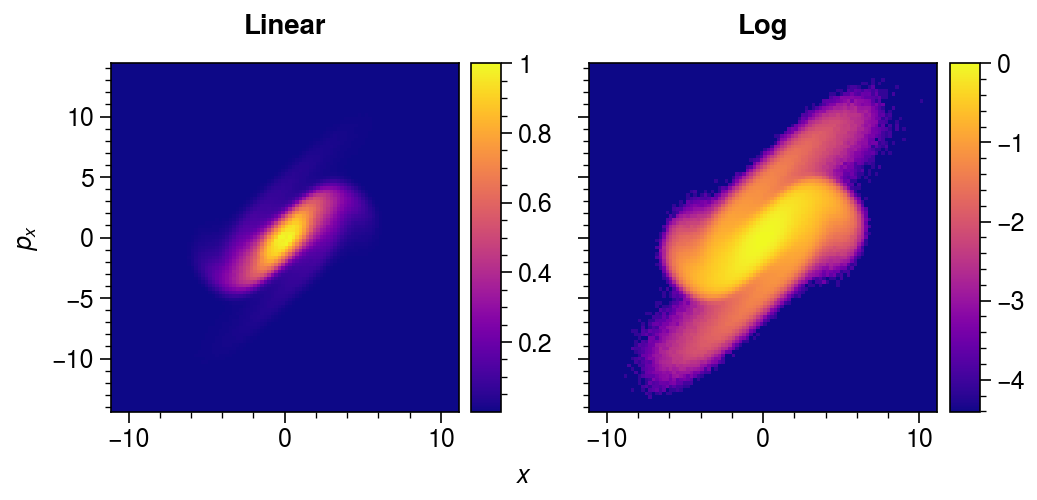

In [4]:
grid = xr.open_dataarray("data/grid.nc")
grid_values = grid.values
grid_coords = [grid.coords["x"].values, grid.coords["xp"].values]

fig, axs = plt.subplots(ncols=2, figheight=2.5)
plot_image(grid_values, grid_coords, ax=axs[0], log=False)
plot_image(grid_values, grid_coords, ax=axs[1], log=True, vmax=0.0)
axs.format(xlabel=r"$x$", ylabel=r"$p_x$", toplabels=["Linear", "Log"])

The plot on the left uses a linear color scale. The most obvious feature is a linear correlation between $x$ and $p_x$, which is caused by the linear quadrpuole focusing/defocusing in the lattice. You can also see some weaker nonlinear correlations near the edge of the distibution, forming the "s" shape characteristic of nonlinear dynamics. The plot on the right uses a *logarithmic* color scale. Notice that the huge nonlinear tails are completely invisible in the other plot.

Let's sample particles from the distribution, remove the linear correlation between $x$ and $p_x$, and scale to unit variance along each dimension.

In [5]:
def sample_grid(values: np.ndarray, coords: list[np.ndarray], size: int, noise: float = 0.0) -> np.ndarray:
    """Sample points from histogram."""
    pdf = np.ravel(values) / np.sum(values)
    idx = np.arange(pdf.size)
    idx = np.random.choice(idx, size, replace=True, p=pdf)
    idx = np.unravel_index(idx, shape=values.shape)

    edges = [ment.coords_to_edges(c) for c in coords]
    lb = [edges[axis][idx[axis]    ] for axis in range(values.ndim)]
    ub = [edges[axis][idx[axis] + 1] for axis in range(values.ndim)]
    
    x = np.zeros((size, values.ndim))
    for axis in range(x.shape[1]):
        x[:, axis] = np.random.uniform(lb[axis], ub[axis])
        if noise:
            delta = 0.5 * noise * (ub[axis] - lb[axis])
            x[:, axis] += np.random.uniform(-delta, delta, size=x.shape[0])
    return x

In [6]:
def norm_matrix_from_cov(cov_matrix: np.ndarray) -> np.ndarray:
    """Symplectic matrix that diagonalizes covariance matrix."""
    emittance = np.sqrt(np.linalg.det(cov_matrix))
    beta = cov_matrix[0, 0] / emittance
    alpha = -cov_matrix[0, 1] / emittance
    V = np.array([[beta, 0.0], [-alpha, 1.0]]) * np.sqrt(1.0 / beta)
    A = np.sqrt(np.diag([emittance, emittance]))
    V = np.matmul(V, A)
    return np.linalg.inv(V)

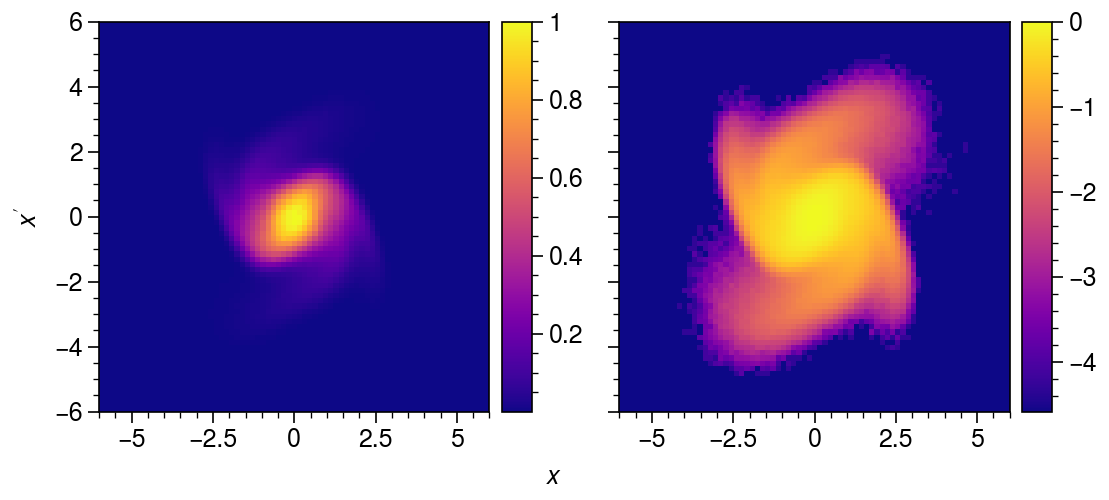

In [7]:
# Sample particles from the discrete distribution.
x_true = sample_grid(values=grid.values, coords=grid.coords.values(), size=8_500_000, noise=1.0)

# Normalize using symplectic matrix.
cov_matrix = np.cov(x_true.T)
norm_matrix = norm_matrix_from_cov(cov_matrix)
x_true = np.matmul(x_true, norm_matrix.T)

# Plot the normalized coordinates.
xmax = 6.0
bins = 75
limits = 2 * [(-xmax, xmax)]

fig, axs = plt.subplots(ncols=2, figheight=2.5)
for i, ax in enumerate(axs):
    plot_points(x_true, bins=bins, limits=limits, ax=ax, log=i)
axs.format(xlabel=r"$x$", ylabel=r"$x'$")

## Forward model

Consider a simple forward model consisting of rotation matrices by angles uniformly spaced between $[0, \pi]$. (In typical measurement beamlines, a linear + uncoupled description of the dyanamics will be sufficient.) We'll simulate 10 measurements.

In [8]:
nmeas = 10 # number of projections
nbins = 75  # number of bins in 1D histograms

# Define rotation angles uniformly spanning [0, pi].
phase_advances = np.linspace(0.0, np.pi, nmeas, endpoint=False)

# Package rotation matrices as LinearTransform function.
transforms = []
for phase_advance in phase_advances:
    matrix = ment.utils.rotation_matrix(phase_advance)
    transform = ment.LinearTransform(matrix)
    transforms.append(transform)

# Create Histogram1D objects.
diagnostics = []
for transform in transforms:
    bin_edges = np.linspace(-xmax, xmax, nbins + 1)
    diagnostic = ment.diag.Histogram1D(axis=0, edges=bin_edges)
    diagnostics.append([diagnostic])

# Generate training data from ground truth distribution. 
projections = ment.simulate(x_true, transforms, diagnostics)

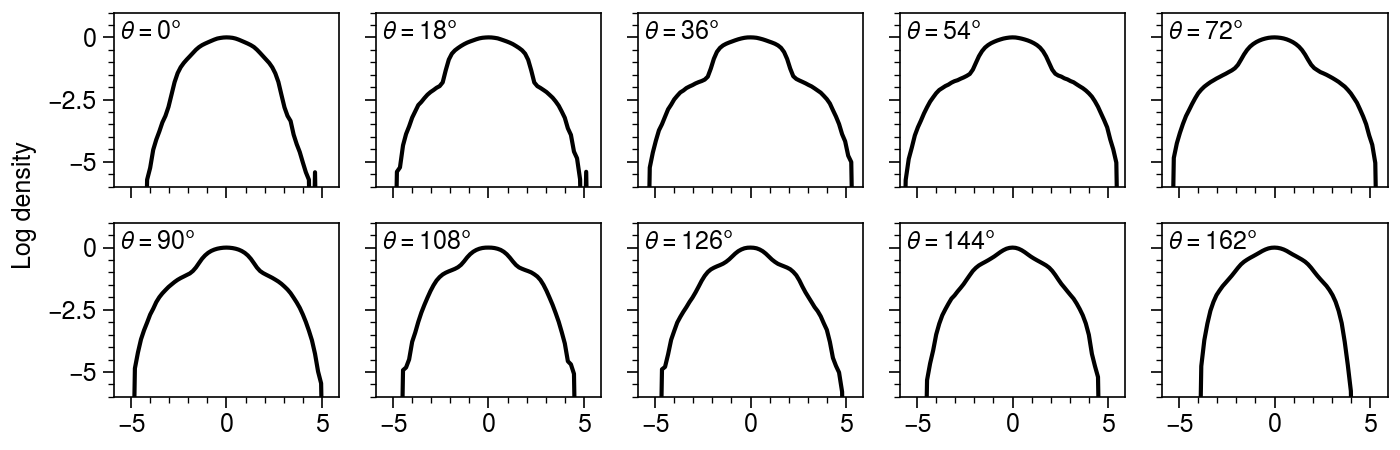

In [9]:
fig, axs = plt.subplots(ncols=5, nrows=2, figheight=2.25, figwidth=7.0)
for ax, projection, phase_advance in zip(axs[:10], ment.unravel(projections), phase_advances):
    values = projection.values.copy()
    values = values / np.max(values)
    log_values = np.log10(values + 1.00e-12)
    ax.plot(projection.coords, log_values, color="black", lw=1.5)
    ax.annotate(r"$\theta = {:0.0f}\degree$".format(np.degrees(phase_advance)), xy=(0.025, 0.85), xycoords="axes fraction")
axs.format(ymax=1.0, ymin=-6.0, ylabel="Log density")

## Reconstruction model

MENT requires a list of transformation functions (`transforms`), which map the distribution from the reconstruction point to each measurement, as well as a list of measured projections (`projections`) as `Histogram1D` objects. It also requires a prior distribution, which we will take to be approximately uniform over the phase space. We will use numerical integration to simulate the projections.

In [10]:
# Defina a wide Gaussian prior (basically uniform).
ndim = 2
prior = ment.GaussianPrior(ndim=ndim, scale=5.0)

# Create sampler to sample particles from the distribution (for plotting).
sampler = ment.GridSampler(grid_limits=limits, grid_shape=(200, 200))

# Define integration grid limits and resolution for each measurement. In this case 
# the grid is one-dimenisonal.
integration_size = 100
integration_limits = [[limits,] for transform in transforms]

# Create MENT reconstruction model.
model = ment.MENT(
    ndim=2,
    projections=projections,
    transforms=transforms,
    prior=prior,
    integration_size=integration_size,
    integration_limits=integration_limits,
    integration_loop=False,  # vectorized
    sampler=sampler,
    mode="integrate",
    interpolation_kws=dict(method="linear"),
    verbose=False,
)

## Training loop

We train MENT using a nonlinear Gauss-Seidel method. This is a relaxation method that gradually pushes the distribution from the prior to the posterior, i.e. from the unconstrained to constrained maximum-entropy distribution.

In [11]:
def plot_model_proj(x_pred: np.ndarray) -> tuple:
    projections_pred = ment.simulate(x_pred, model.transforms, model.diagnostics)
    projections_pred = ment.unravel(projections_pred)
    projections_meas = ment.unravel(model.projections)

    fig, axs = plt.subplots(ncols=5, nrows=2, figheight=2.5, figwidth=7.0)
    index = 0
    for index in range(nmeas):
        ax = axs[index]
        projection_pred = projections_pred[index]
        projection_meas = projections_meas[index]            
        scale = projection_meas.values.max()
        ax.plot(projection_pred.coords, np.log10(projection_pred.values / scale + 1.00e-12), color="black", lw=1.5, alpha=0.25)
        ax.plot(projection_meas.coords, np.log10(projection_meas.values / scale + 1.00e-12), color="black", lw=0.0, ms=2.0, marker=".")
        ax.format(ymax=0.5, ymin=-6.0)
        ax.annotate(f"{i:02.0f}", xy=(0.02, 0.85), xycoords="axes fraction")
    axs.format(xlabel=r"$x$", ylabel="Log density")
    return fig, axs

In [12]:
def plot_model_dist(x_pred: np.ndarray) -> tuple:
    fig, axs = plt.subplots(ncols=2, figheight=2.5)
    for ax, x in zip(axs, [x_pred, x_true]):
        plot_points(x, bins=85, limits=limits, ax=ax, log=True)
    axs.format(
        toplabels=["MENT", "TRUE"], 
        toplabels_kw=dict(weight="normal", size="medium"), 
        xlabel=r"$x$",
        ylabel=r"$p_x$",
    )
    return fig, axs

epoch = 0


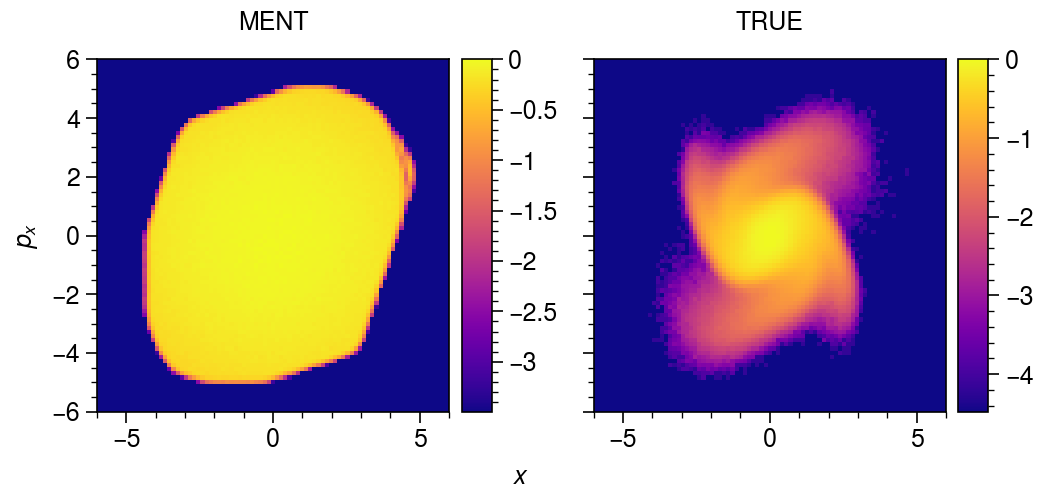

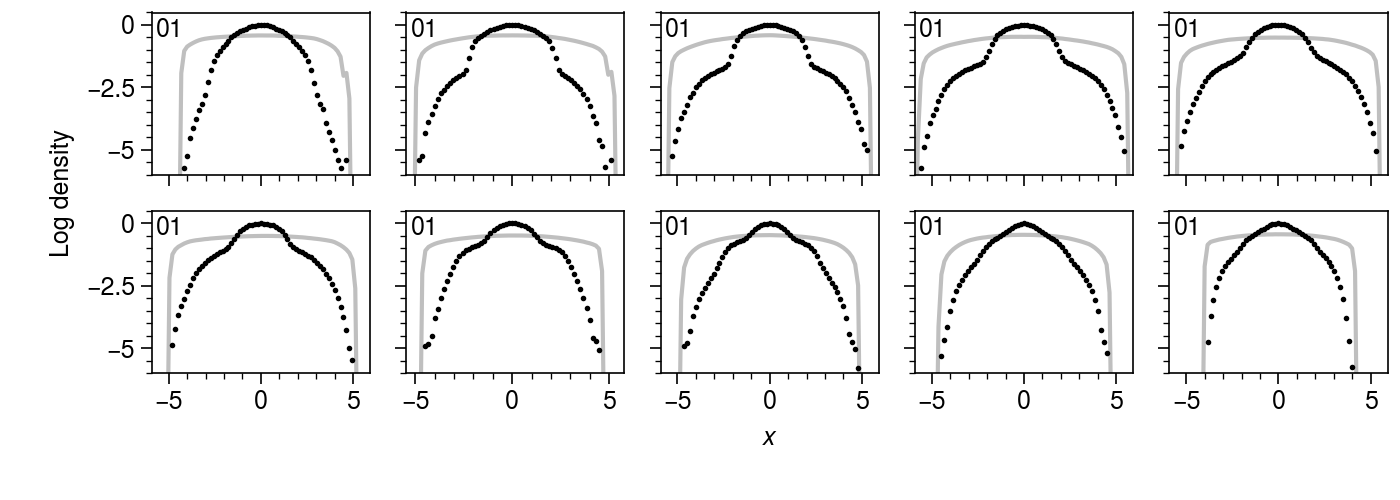

epoch = 1


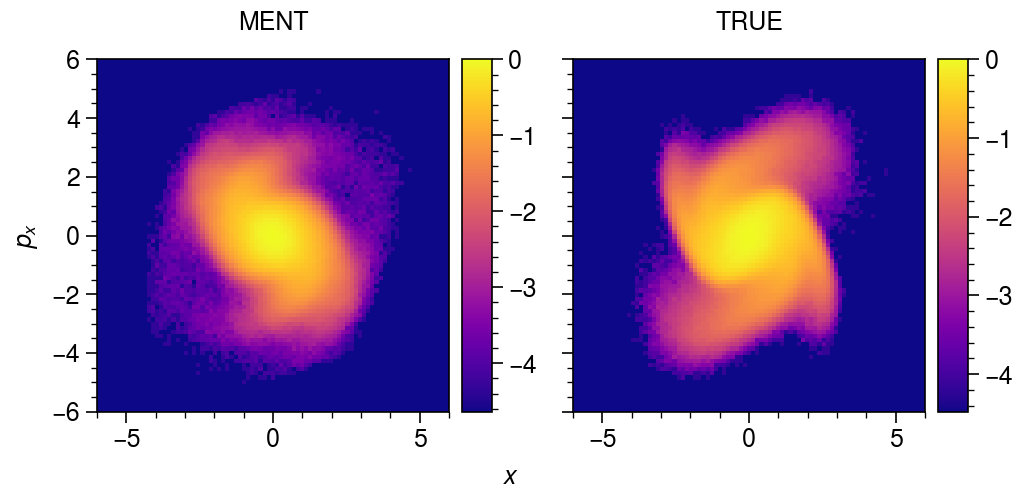

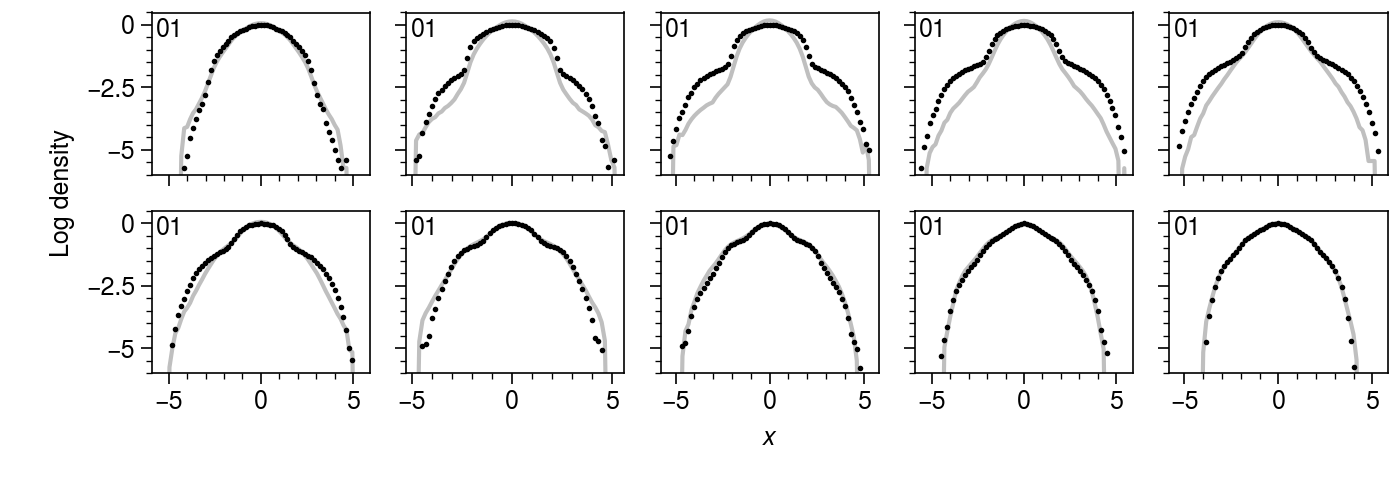

epoch = 2


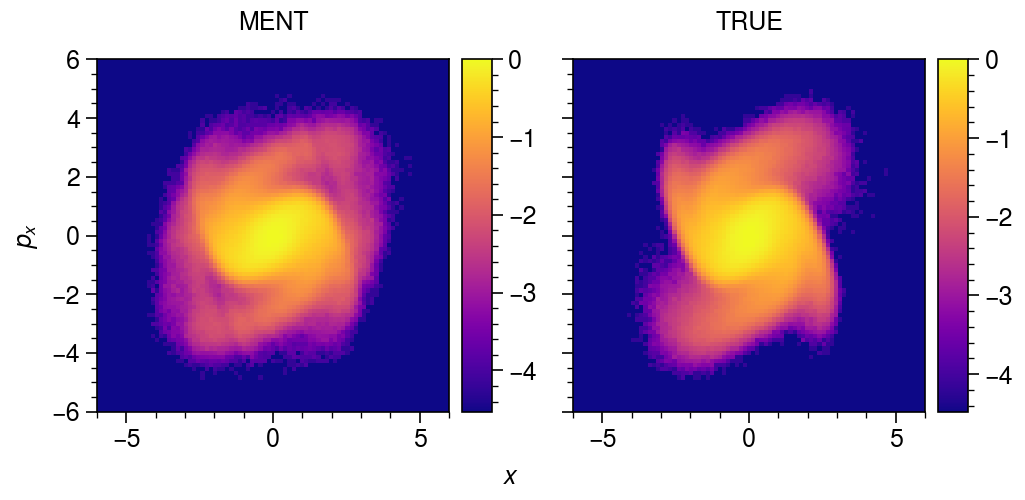

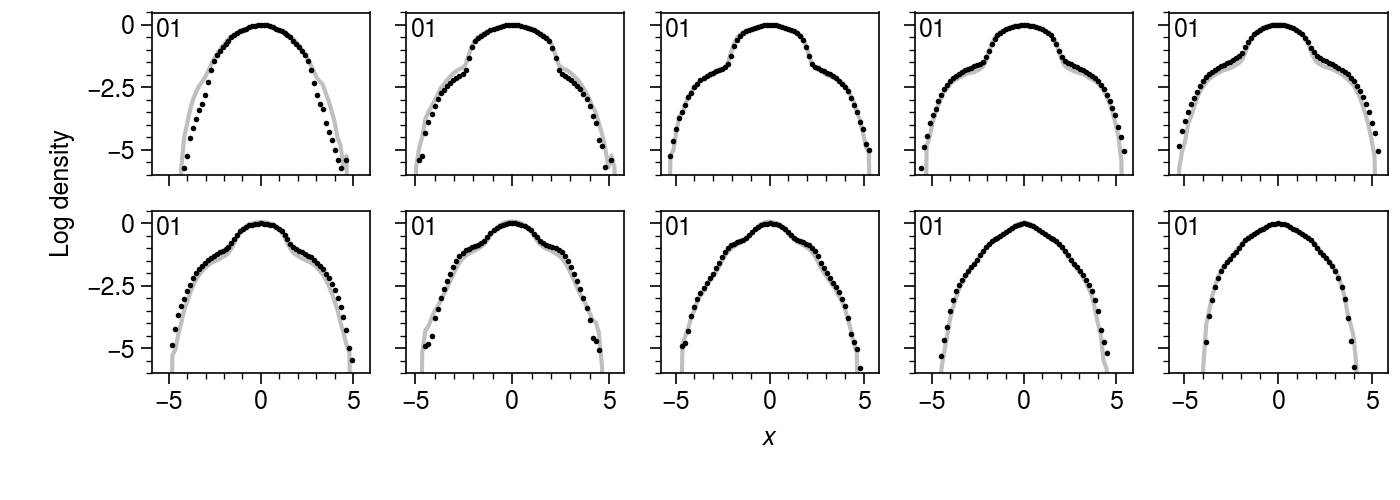

epoch = 3


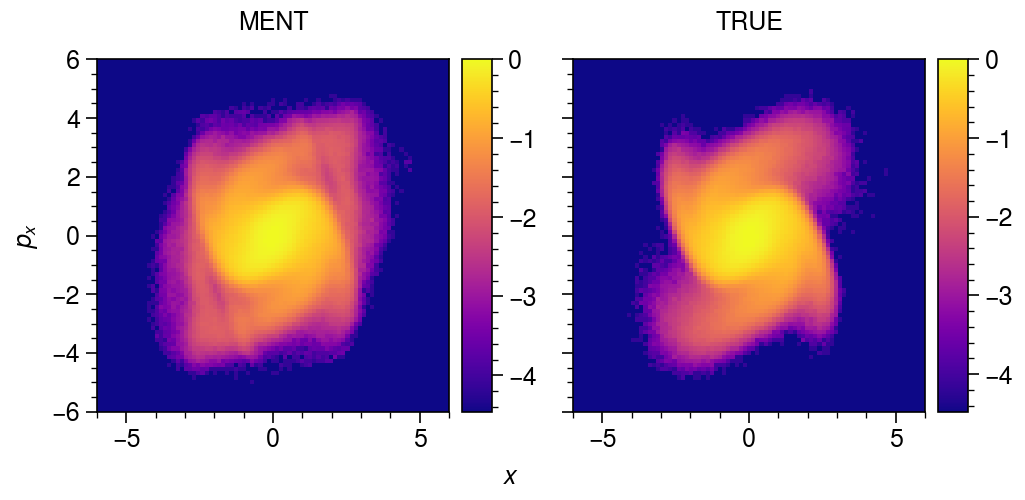

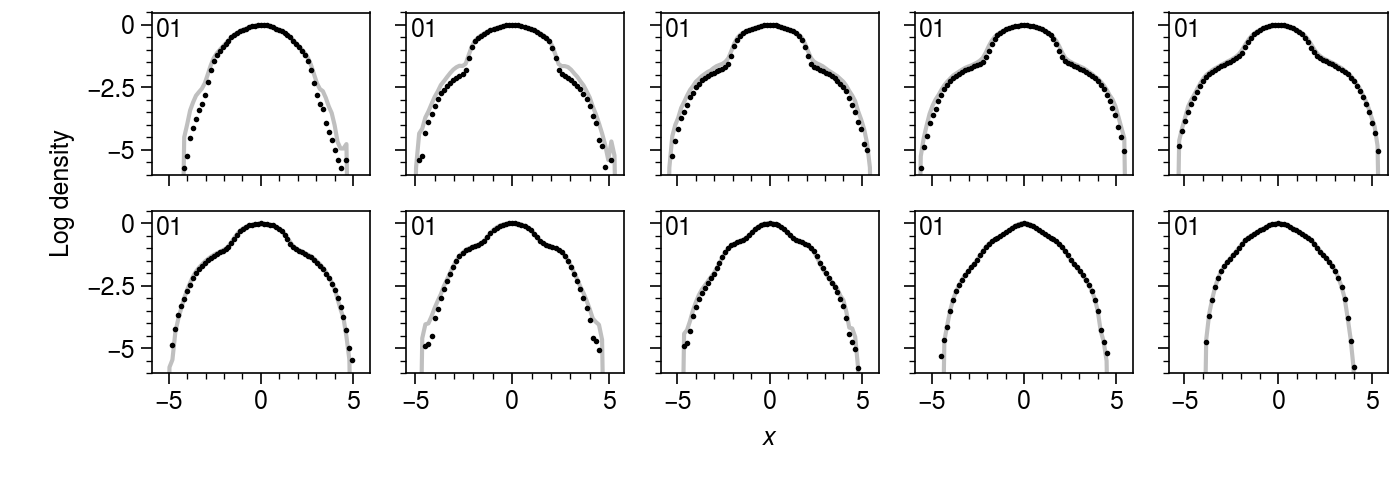

epoch = 4


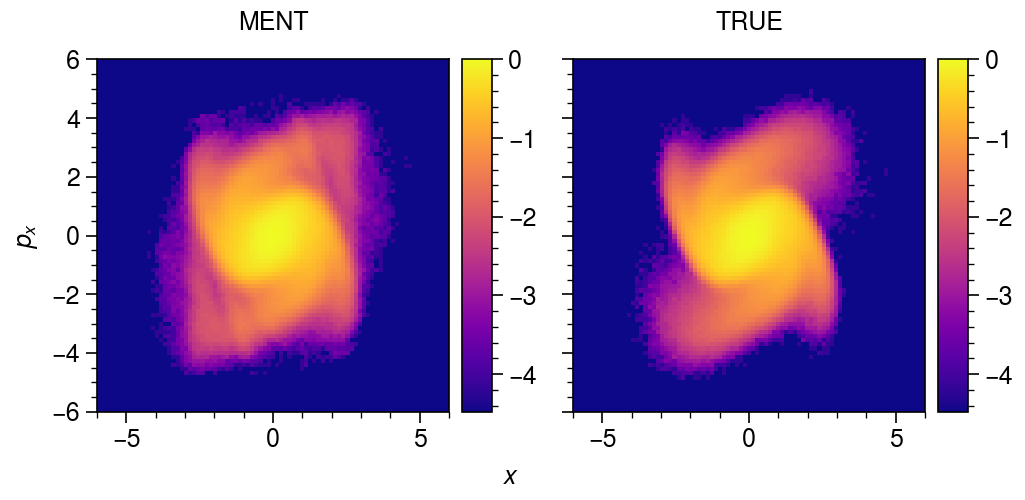

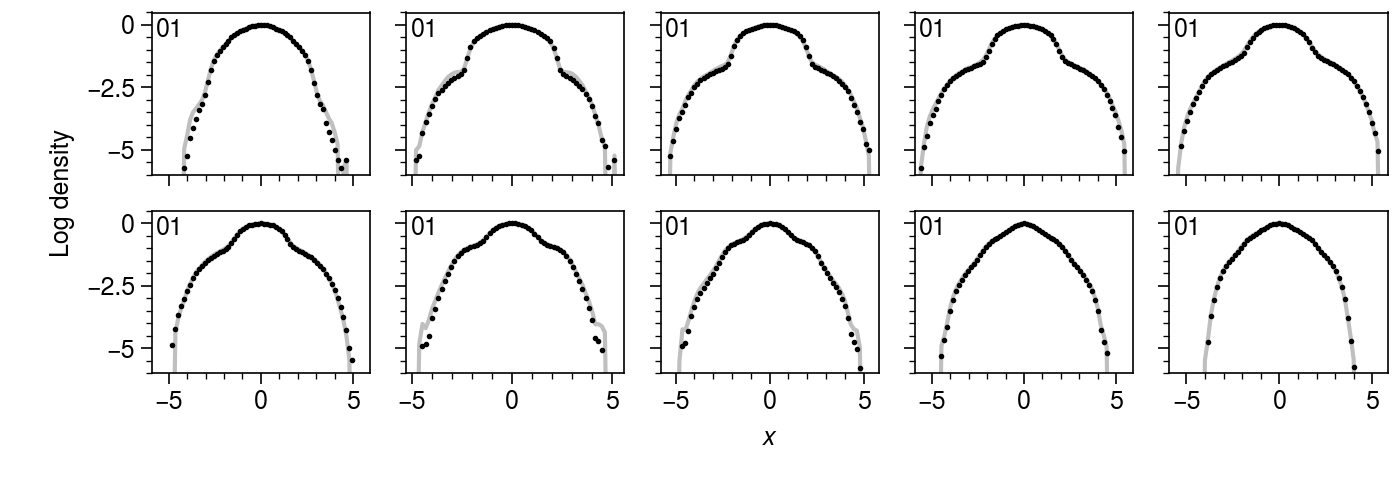

epoch = 5


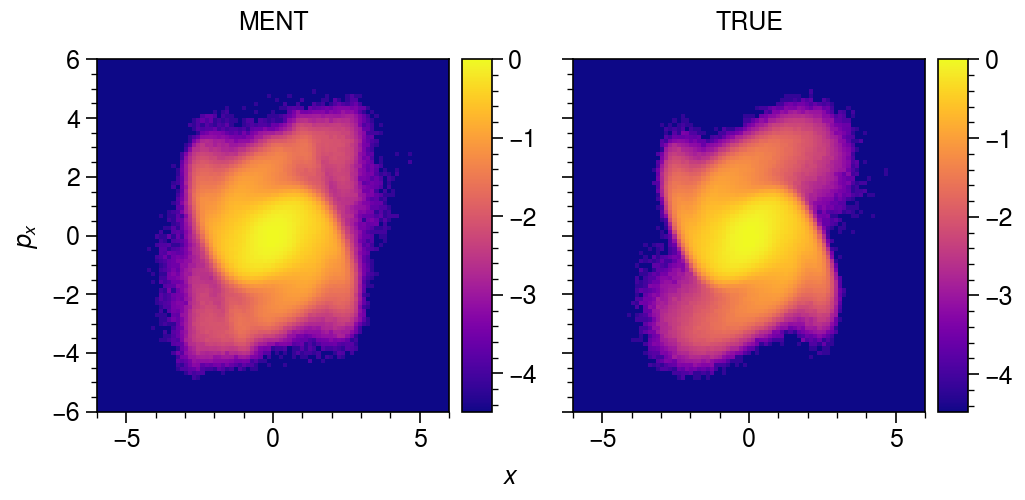

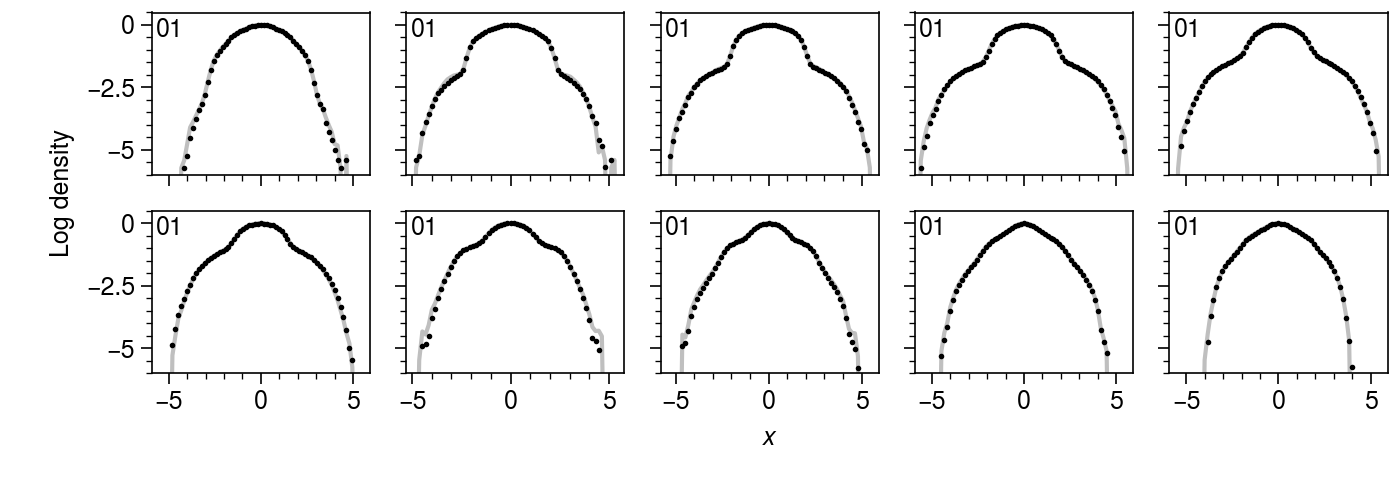

epoch = 6


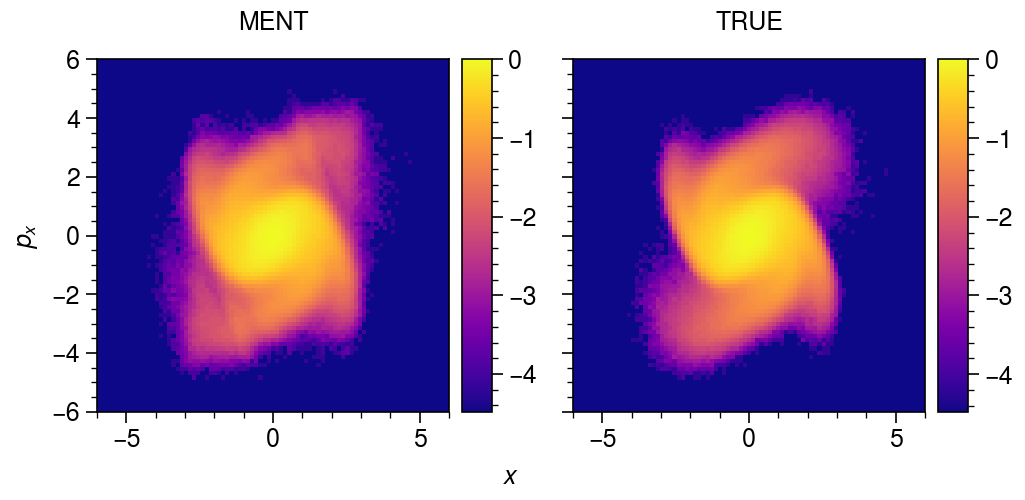

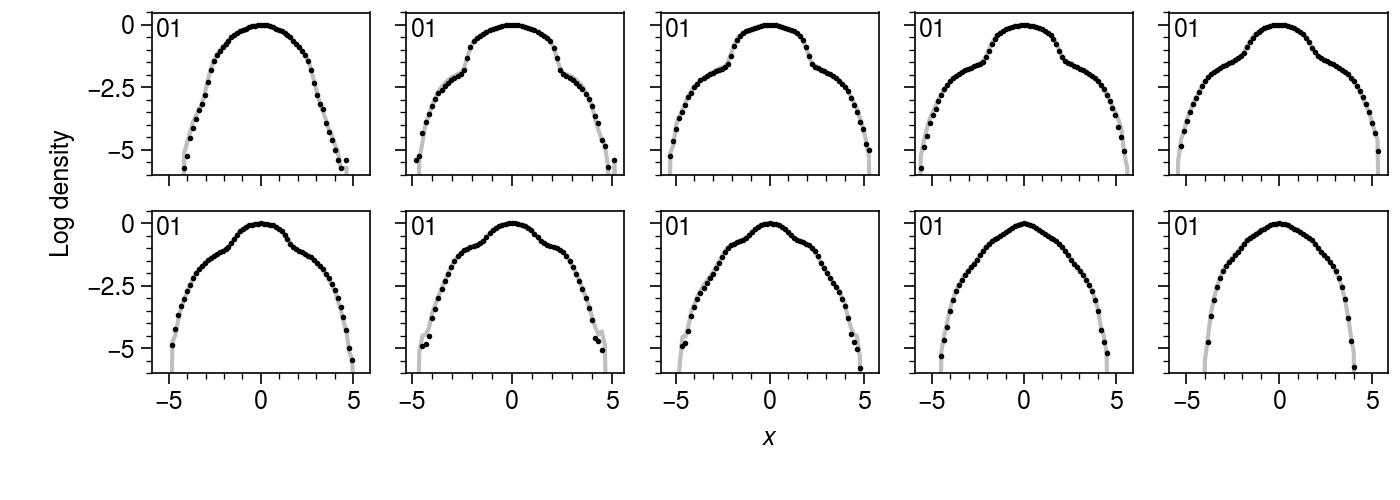

In [13]:
for epoch in range(7):
    print("epoch = {}".format(epoch))

    # Sample particles from the distribution.
    x_pred = model.sample(x_true.shape[0])

    # Plot the phase space density.
    plot_model_dist(x_pred)
    plt.show()

    # Plot the simulated vs. measured projections.
    plot_model_proj(x_pred)
    plt.show()
    
    # Update the model parameters (Lagrange multipliers).
    model.gauss_seidel_step(learning_rate=0.85)